# Imports and program variables


In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

from time_series_dataset_loader import TimeSeriesDatasetLoader

from sklearn.model_selection import train_test_split # to split dataset into train and test
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/home/moutinho/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/moutinho/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/moutinho/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/moutinho/.local/lib/python3.6/site-packages/tensorflo

In [21]:
DATASET_PATH = '../datasets/MFCC'

## Setting up train and test datasets

In [22]:
dataset_loader = TimeSeriesDatasetLoader(DATASET_PATH)
X, y = dataset_loader.get_dataset()

In [23]:
X = np.asarray(X)
y = np.asarray(y)

In [24]:
# Completing with zeros
max_len = len(X[0])
for row in X:
        if len(row) > max_len:
            max_len = len(row)

X = pad_sequences(X, maxlen=max_len, padding='post')

In [25]:
# See X and y details
print(X[:2])
print(X.shape)

print(y[:3])
print(y.shape)

[[[ 0  0 -7 ...  0  2 -2]
  [ 1  0 -7 ...  0  5 -1]
  [ 2  0 -7 ...  1  1 -1]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0 11 ...  0  0 -9]
  [ 1  0 13 ... -1  0 -6]
  [ 2  0 11 ... -6  0 -5]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]]
(1066, 543, 16)
[3 0 1]
(1066,)


In [26]:
# Split the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)

print("\ny_train:\n")
print(y_train[:3])
print(y_train.shape)

print("\ny_test:\n")
print(y_test[:3])
print(y_test.shape)


X_train:

[  0   0   8  -2   7  -2  10   5  -3  -6  16  -5  -1  -4   1 -10]
(746, 543, 16)

X_test:

[  0   0  -4   0   4   9   2   5   2  13   4   9   8  -1   5 -25]
(320, 543, 16)

y_train:

[0 2 2]
(746,)

y_test:

[1 5 4]
(320,)


In [27]:
# Create categorical matrices
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [28]:
num_rows = X[0].shape[0]
num_columns = X[0].shape[1]
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)


X_train:

[[  0]
 [  0]
 [  8]
 [ -2]
 [  7]
 [ -2]
 [ 10]
 [  5]
 [ -3]
 [ -6]
 [ 16]
 [ -5]
 [ -1]
 [ -4]
 [  1]
 [-10]]
(746, 543, 16, 1)

X_test:

[[  0]
 [  0]
 [ -4]
 [  0]
 [  4]
 [  9]
 [  2]
 [  5]
 [  2]
 [ 13]
 [  4]
 [  9]
 [  8]
 [ -1]
 [  5]
 [-25]]
(320, 543, 16, 1)


## Building and Compiling Model

In [29]:
# Construct model 1
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(7, activation='softmax'))

In [34]:
# top-k category accuracy
import functools
import keras
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',top3_acc])

In [36]:
# Define bath and epochs
batch_size = 256
epochs = 100

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.0000001)
mcp_save = ModelCheckpoint('../models/model_checkpoints/default.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test), callbacks=[mcp_save, lr_reduce])

Train on 746 samples, validate on 320 samples
Epoch 1/100
746/746 [==============================] - 8s 10ms/step - loss: 1.4523 - accuracy: 0.4477 - top3_acc: 0.8204 - val_loss: 1.6931 - val_accuracy: 0.2656 - val_top3_acc: 0.7437
Epoch 2/100
746/746 [==============================] - 6s 8ms/step - loss: 1.4423 - accuracy: 0.4544 - top3_acc: 0.8137 - val_loss: 1.8904 - val_accuracy: 0.2562 - val_top3_acc: 0.6187
Epoch 3/100
746/746 [==============================] - 6s 8ms/step - loss: 1.4310 - accuracy: 0.4357 - top3_acc: 0.8271 - val_loss: 1.6649 - val_accuracy: 0.3063 - val_top3_acc: 0.7500
Epoch 4/100
746/746 [==============================] - 6s 8ms/step - loss: 1.4270 - accuracy: 0.4477 - top3_acc: 0.8257 - val_loss: 1.8734 - val_accuracy: 0.2438 - val_top3_acc: 0.6531
Epoch 5/100
746/746 [==============================] - 7s 9ms/step - loss: 1.4306 - accuracy: 0.4571 - top3_acc: 0.8311 - val_loss: 1.7013 - val_accuracy: 0.2781 - val_top3_acc: 0.7219
Epoch 6/100
746/746 [=======

Epoch 45/100
746/746 [==============================] - 8s 11ms/step - loss: 1.3290 - accuracy: 0.4920 - top3_acc: 0.8499 - val_loss: 1.8188 - val_accuracy: 0.2688 - val_top3_acc: 0.6969
Epoch 46/100
746/746 [==============================] - 9s 12ms/step - loss: 1.3004 - accuracy: 0.4933 - top3_acc: 0.8713 - val_loss: 1.6565 - val_accuracy: 0.3094 - val_top3_acc: 0.7531
Epoch 47/100
746/746 [==============================] - 10s 13ms/step - loss: 1.3533 - accuracy: 0.4826 - top3_acc: 0.8552 - val_loss: 1.9304 - val_accuracy: 0.2688 - val_top3_acc: 0.6531
Epoch 48/100
746/746 [==============================] - 10s 14ms/step - loss: 1.3476 - accuracy: 0.4705 - top3_acc: 0.8606 - val_loss: 1.6470 - val_accuracy: 0.3156 - val_top3_acc: 0.7719
Epoch 49/100
746/746 [==============================] - 10s 13ms/step - loss: 1.3269 - accuracy: 0.5040 - top3_acc: 0.8458 - val_loss: 1.8481 - val_accuracy: 0.2844 - val_top3_acc: 0.6938
Epoch 50/100
746/746 [==============================] - 8s 10m

Epoch 89/100
746/746 [==============================] - 9s 11ms/step - loss: 1.2424 - accuracy: 0.5201 - top3_acc: 0.8740 - val_loss: 1.7726 - val_accuracy: 0.3125 - val_top3_acc: 0.7125
Epoch 90/100
746/746 [==============================] - 8s 11ms/step - loss: 1.2666 - accuracy: 0.5134 - top3_acc: 0.8700 - val_loss: 1.6571 - val_accuracy: 0.3375 - val_top3_acc: 0.7750
Epoch 91/100
746/746 [==============================] - 8s 11ms/step - loss: 1.2549 - accuracy: 0.5322 - top3_acc: 0.8606 - val_loss: 1.8658 - val_accuracy: 0.3094 - val_top3_acc: 0.6906
Epoch 92/100
746/746 [==============================] - 9s 12ms/step - loss: 1.2556 - accuracy: 0.5027 - top3_acc: 0.8820 - val_loss: 1.6317 - val_accuracy: 0.3344 - val_top3_acc: 0.7875
Epoch 93/100
746/746 [==============================] - 8s 11ms/step - loss: 1.2744 - accuracy: 0.5268 - top3_acc: 0.8660 - val_loss: 1.8526 - val_accuracy: 0.2937 - val_top3_acc: 0.7000
Epoch 94/100
746/746 [==============================] - 9s 12ms/s

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 542, 15, 32)       160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 271, 7, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 271, 7, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 270, 6, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 135, 3, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 135, 3, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 134, 2, 128)      

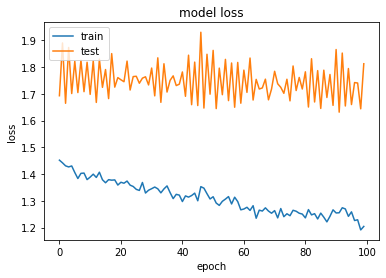

In [37]:
import matplotlib.pyplot as plt

# Model Summary

model.summary()

# PLT History info
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()